In [51]:
#importacion general de librerias y de visualizacion (matplotlib y seaborn)
%matplotlib notebook
%config IPCompleter.greedy=True
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
import emoji
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


#pd.set_option('display.max_colwidth', None)



plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (20, 10)
sns.set(style="whitegrid") # seteando tipo de grid en seaborn
pd.options.display.float_format = '{:20,.10f}'.format # suprimimos la notacion cientifica en los outputs

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


from IPython.core.pylabtools import figsize
plt.rcParams['figure.figsize'] = (9, 6)


In [52]:
df = pd.read_csv('train.csv', encoding='utf-8')

df['location'].fillna(value='sin location', inplace=True)
df['keyword'].fillna(value='sin keyword', inplace=True)

df['text'] = df.text.str.lower()
df['text'] = df.text.str.replace('%20', ' ')

df['keyword'] = df.keyword.str.lower()
df['keyword'] = df.keyword.str.replace('%20', ' ')

df['location'] = df.location.str.lower()
df['location'] = df.location.str.replace('%20', ' ')

# Funciones Generales

In [53]:

NOTICIEROS = ['cnn', 'bbc', 'reuters', 'blomberg', 'herald', 'today', 'herald', 'abc', 'fox', 'cbs', \
            'yorker', 'daily', 'financial', 'guardian', 'sun', 'observer', 'five', 'jazeera', 'news', 'live']
PAIS_DESASTRES = ['usa', 'united states', 'canada', 'japan', 'nigeria']
CIUDAD_DESASTRES = ['california', 'new york', 'nyc', 'hawaii']

TRAGEDIAS_CONOCIDAS = ['mh370', 'huracan', ]

CORTE_LENGHT_TEXT = 100

#Imprimir metricas de las predicciones
def print_metrics(y_test, y_pred):
    #auc = metrics.roc_auc_score(y_test, y_pred) #AUC
    precision = metrics.precision_score(y_test, y_pred) #Precisión
    accuracy = metrics.accuracy_score(y_test, y_pred) #Accuracy
    f1 = metrics.f1_score(y_test, y_pred) #F1 
    conf_matrix = metrics.confusion_matrix(y_test, y_pred) #Matriz de confusión
    #recall = metrics.recall_score(y_test, y_pred) #Recall 
    print('Accuracy:', accuracy, 'F1: ', f1,  'Precisión: ', precision)

# Referencia a un diario o noticiero
def news_ref(text):
    for word in text.split():
        if word in NOTICIEROS:
            return True
    return False

#Categoría ancho mensajes
def text_lenght_category(text):
    if len(text) > CORTE_LENGHT_TEXT:
        return True
    else:
        return False

#Pais de desastre
def es_pais_de_desastres(text):
    for word in text.split():
        if word in PAIS_DESASTRES:
            return True
    return False

#Ciudad de desastre
def es_ciudad_de_desastres(text):
    for word in text.split():
        if word in CIUDAD_DESASTRES:
            return True
    return False

In [54]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tag import pos_tag


import re, string
from string import punctuation


stops = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stops.update(punctuation)

def unir_texto(text):
    return ( " ".join(text))

#englishStemmer=SnowballStemmer("english")
def limpiar_texto(word):
    word = word.replace('#', '')
    if word.startswith('http') | word.startswith('http'):
        word = ''
    word = re.sub('[^A-Za-z0-9]+', ' ', word)
    return word

# Tipo de palabra
#https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

#Lematizar palabras
lemmatizer = WordNetLemmatizer()
def lematizar(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stops:
            pos = pos_tag([i.strip()])
            word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            final_text.append(word.lower())
    return final_text
def formatear_texto(text):
    text = limpiar_texto(text)
    text = lematizar(text)
    text = unir_texto(text)
    return text
    

In [55]:
df['text_sin_sw'] = df.text.apply(formatear_texto)

df['length'] = df.text_sin_sw.apply(len)


df['http'] = df.text.str.contains('http')
#df['carita_alegre'] = df.text.str.contains(':\)')
#df['carita_triste'] = df.text.str.contains(':\(')
#df['cant_stopwords'] = df.text.apply(lambda x: len(set(x.split()) & stops))


df['ref_noticias'] = df.text_sin_sw.apply(news_ref)

df['zona_desastres'] = df.text_sin_sw.apply(es_ciudad_de_desastres) |\
                        df.text_sin_sw.apply(es_pais_de_desastres)


'''
X = df[['location', 'text_sin_sw', 'target', 'http_hashtag', 'carita_alegre', 'carita_triste', 'length_verdadero', 'ref_noticias', 'zona_desastres']].join(encoded)
X[X.target == 1].sample(400).to_csv('data/tw_reales.csv')
X[X.target == 0].sample(400).to_csv('data/tw_falsos.csv')
df.sample(100)
'''

#serie = df[df.target == 0]['text_sin_sw'].str.split(expand=True).stack().value_counts()
#serie.to_csv('data/tw_top_words_0.csv')
#df[df.zona_desastres == 1].to_csv('data/sampple.csv')

df.text.str.contains('Omg').sum()

0

# Pruebas

In [56]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer

X = df['text_sin_sw']
y = df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

#Train
KNN = KNeighborsClassifier(n_neighbors = 91)
KNN.fit(X_train, y_train)

#Métricas
y_pred = KNN.predict(X_test)
print_metrics(y_test, y_pred)

Accuracy: 0.7914915966386554 F1:  0.7229588276343336 Precisión:  0.8144654088050315


# Buscando un K 'bueno'

<IPython.core.display.Javascript object>


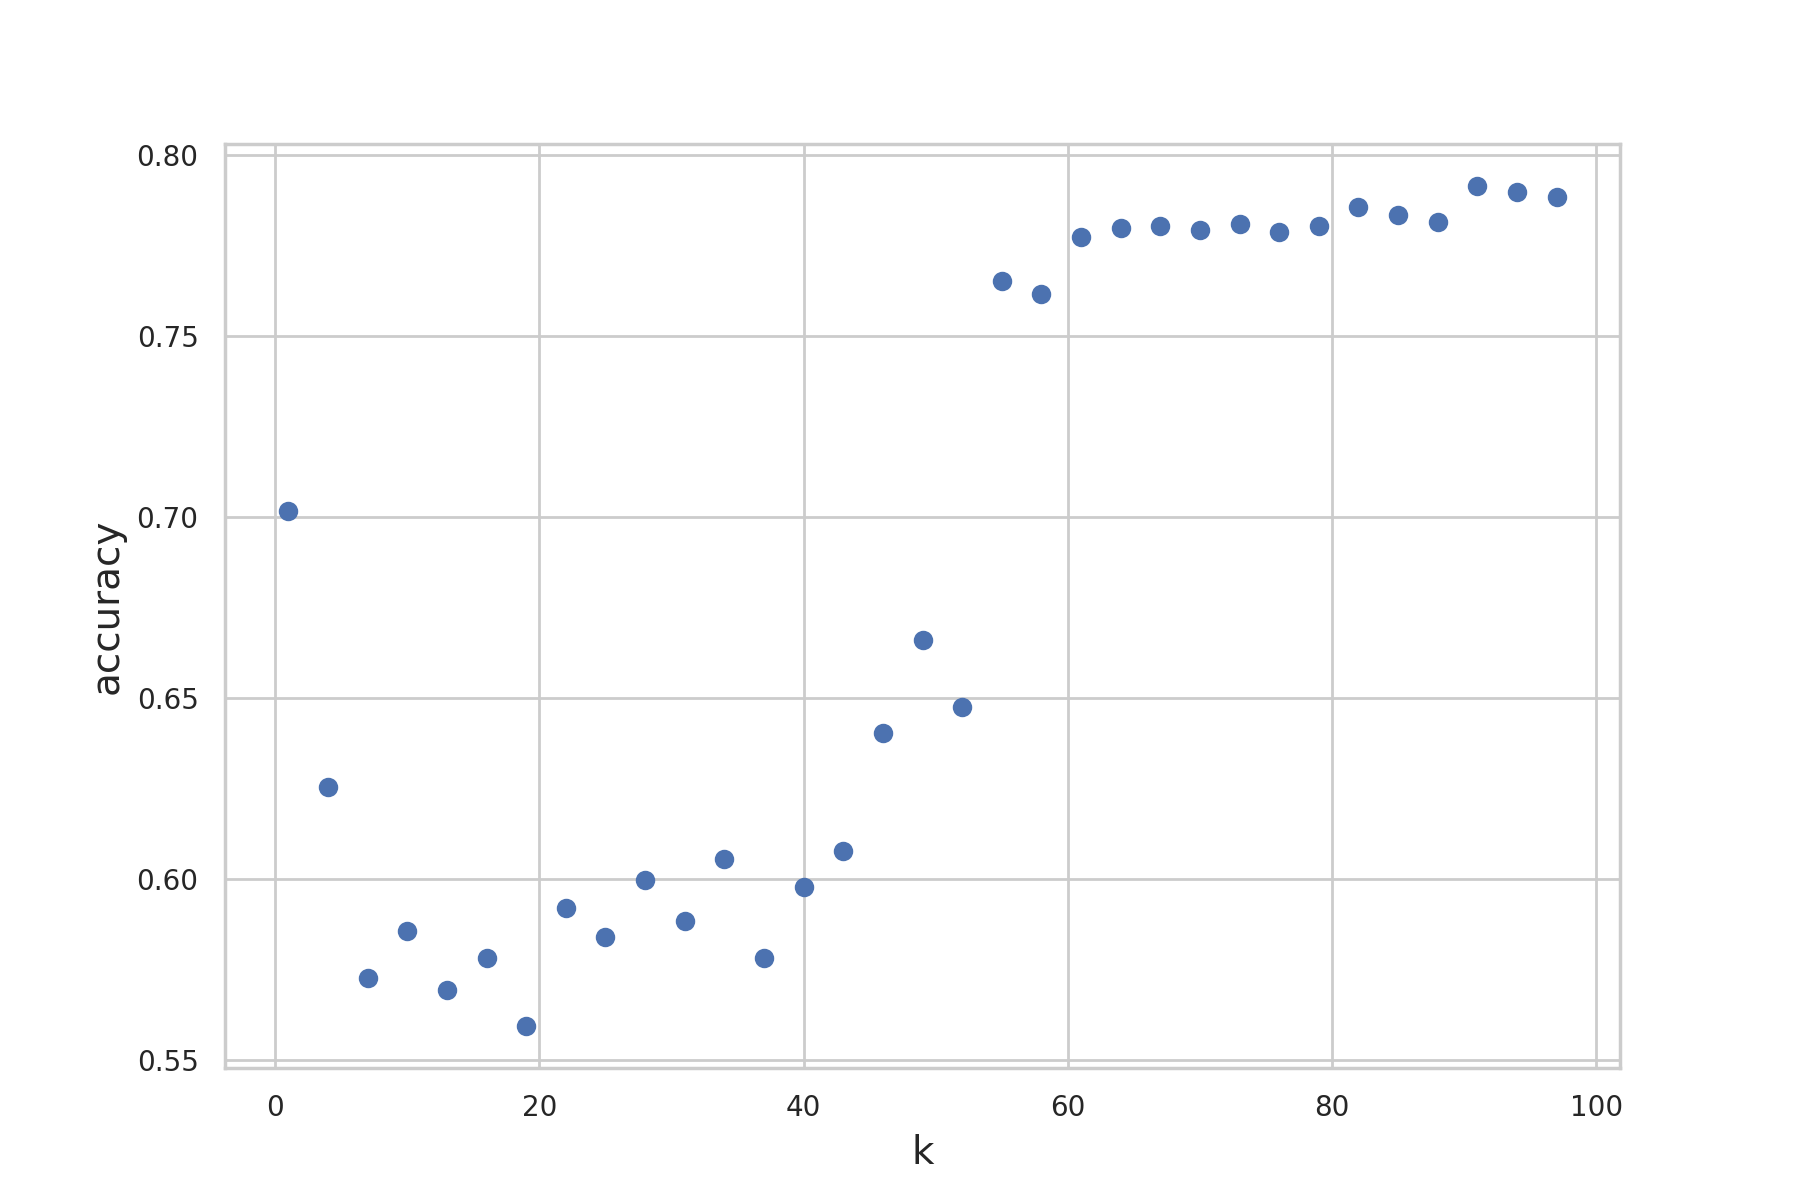

In [57]:
k_range = range(1,100, 3)
scores = []


for k in k_range:
    KNN = KNeighborsClassifier(n_neighbors = k)
    KNN.fit(X_train, y_train)
    scores.append(KNN.score(X_test, y_test))
   # accuracy = metrics.accuracy_score(y_test, y_pred) #Accuracy

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.show()


# Datos de entrenamiento

In [58]:
from sklearn.preprocessing import LabelEncoder


#Codificando como categorias
#cat_features = ['ciudad_text', 'ciudad_location', 'pais_text', 'pais_location']
#encoder = LabelEncoder()

# Apliico a cada columna
#encoded = df[cat_features].apply(encoder.fit_transform)


#Datos de entrenameinto
#X = df[['http_hashtag', 'carita_alegre', 'carita_triste', 'length', 'ref_noticias', 'zona_desastres']].join(encoded)

#y = df['target']
#columnas = ['id', 'keyword', 'location', 'text', 'target', 'text_sin_sw']
#X = df.drop(columnas, axis=1)




# 1. KNN

In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer

X = df['text_sin_sw']
y = df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

#Train
KNN = KNeighborsClassifier(n_neighbors = 91)
KNN.fit(X_train, y_train)

#Métricas
y_pred = KNN.predict(X_test)
print_metrics(y_test, y_pred)

Accuracy: 0.7914915966386554 F1:  0.7229588276343336 Precisión:  0.8144654088050315


# 2 . Regresión Logística

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = df['text_sin_sw']
y = df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


#Entrenamiento
LR = LogisticRegression(penalty='l2', max_iter=500, C=1.5, random_state = 1)
LR.fit(X_train, y_train)

#Métricas
y_pred_lr = LR.predict(X_test)
print_metrics(y_test, y_pred_lr)



Accuracy: 0.8135504201680672 F1:  0.7641196013289037 Precisión:  0.8121468926553672


# 3. Multinomial NB

In [61]:
from sklearn.naive_bayes import MultinomialNB

X = df['text_sin_sw']
y = df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

# Train
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

#Predict
y_pred_gnb = MNB.predict(X_test)

print_metrics(y_test, y_pred_gnb)

Accuracy: 0.8061974789915967 F1:  0.7417774667599721 Precisión:  0.8386075949367089


# 4. RFC - Num

Accuracy: 0.6339285714285714 F1:  0.5368770764119601 Precisión:  0.5706214689265536


<IPython.core.display.Javascript object>


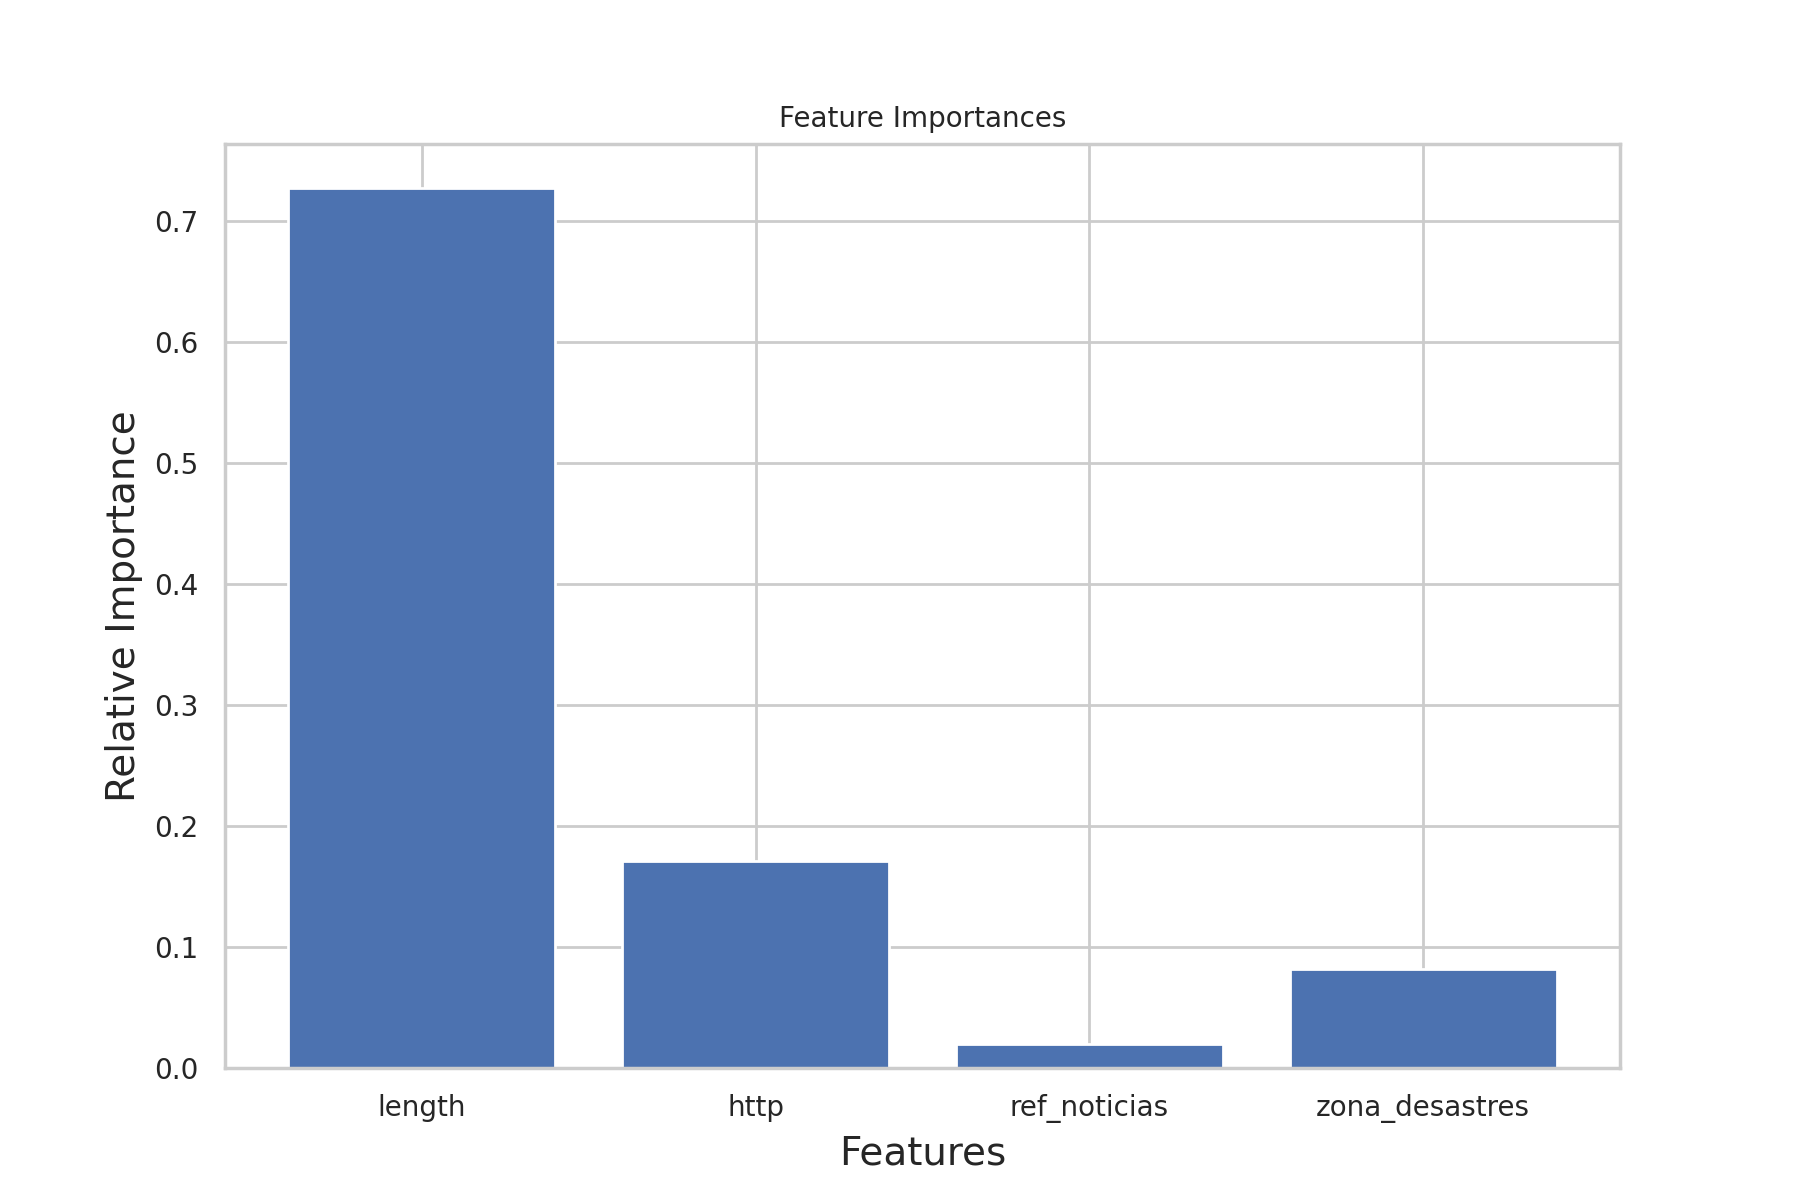

Feature ranking:
[72.69906466 17.07279744  2.01749676  8.21064114]


In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#Datos de entrenameinto
#X = df[['http_hashtag', 'carita_alegre', 'carita_triste', 'length', 'ref_noticias', 'zona_desastres']].join(encoded)

y = df['target']
columnas = ['id', 'keyword', 'location', 'text', 'target', 'text_sin_sw']
X = df.drop(columnas, axis=1)

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Train
RFC = RandomForestClassifier(n_estimators = 20,  n_jobs=-1, random_state = 0)
RFC.fit(X_train, y_train)

#Predict
y_pred = RFC.predict(X_test)

#metrics
print_metrics(y_test, y_pred)

#Features

features = np.array(X.columns)
importances = RFC.feature_importances_



    
plt.figure()
plt.bar(X_train.columns, importances)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Relative Importance')
plt.show()

# Print the feature ranking
print("Feature ranking:")

print(importances*100)



# 5. RFC - Text

In [63]:
from sklearn.ensemble import RandomForestClassifier

X = df['text_sin_sw']
y = df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

# Train
RFC = RandomForestClassifier(n_estimators = 20,  n_jobs=-1, random_state = 0)
RFC.fit(X_train, y_train)

#Predict
y_pred = RFC.predict(X_test)

#metrics
print_metrics(y_test, y_pred)



Accuracy: 0.789390756302521 F1:  0.7104693140794224 Precisión:  0.8367346938775511
